<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
df_house = pd.read_csv('./housing.csv')

In [3]:
# A:
df_house.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
959,960,160,FV,24.0,2572,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,155000
1183,1184,30,RL,60.0,10800,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,120000
1082,1083,20,RL,70.0,8749,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2007,WD,Normal,192000
1285,1286,50,RM,50.0,6000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,132500
1437,1438,20,RL,96.0,12444,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2008,New,Partial,394617


In [4]:
df_house.shape

(1460, 81)

In [5]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

# 1. Drop non-residential data from the DataFrame

In [6]:
df_house['MSZoning'].unique()

# Based on the data dictionary, these are the non-residential types in the 'MSZoning' column:
# A	Agriculture
# C	Commercial    
# FV	Floating Village Residential   
# I	Industria

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [7]:
df_house = df_house[(df_house['MSZoning'] != 'C (all)')]
df_house = df_house[(df_house['MSZoning'] != 'FV')]

In [8]:
df_house['MSZoning'].unique()

array(['RL', 'RM', 'RH'], dtype=object)

# 2. Perform any cleaning, feature engineering, and EDA you deem necessary.

In [9]:
df_house.shape

(1385, 81)

In [10]:
# B. List all the columns to classify them into different category types like:
# quality columns
# condition columns
# heat / electric columns

df_house.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

In [11]:
column_quality = ['OverallQual', 'ExterQual', 'BsmtQual', 'BsmtFinType1', 'BsmtFinType2', 'KitchenQual', 
                  'FireplaceQu', 'GarageQual', 'Fence', 'PoolQC']
column_condition = ['OverallCond', 'ExterCond', 'BsmtCond', 'GarageCond']
column_heat_elec = ['Heating', 'HeatingQC', 'CentralAir', 'Electrical']

In [12]:
#list comprehension for all other columns
column_all_others = [col for col in df_house.columns if (col not in (column_quality + 
                                                                     column_condition + 
                                                                     column_heat_elec)) ]

# check that the lenght of columns_all_others = 81 - 10 (quality) - 4 (condition) - 4 (heat/electric)
len(column_all_others)

63

In [13]:
# B.2 clean up null values in the df_house dataframe by inspecting subsetted dataframes
df_quality = df_house[column_quality]
df_quality.isnull().sum()

OverallQual        0
ExterQual          0
BsmtQual          37
BsmtFinType1      37
BsmtFinType2      38
KitchenQual        0
FireplaceQu      641
GarageQual        79
Fence           1108
PoolQC          1378
dtype: int64

In [14]:
# B.2.a Look at the basebement metric. Where there is total basement SF of 0, there should be NA in condition
# and quality metrics. Convert the NaNs into 'NA' and then subsequently use the label encoder for certain
# quality and or condition metrics for the basement to clean and ulitmately run through feature selection process

df_house[df_house['TotalBsmtSF'] == 0][['TotalBsmtSF', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                                        'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF']].sample(5)

,TotalBsmtSF,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF
39,0,NaN,NaN,NaN,NaN,0,NaN,0,0
392,0,NaN,NaN,NaN,NaN,0,NaN,0,0
1232,0,NaN,NaN,NaN,NaN,0,NaN,0,0
736,0,NaN,NaN,NaN,NaN,0,NaN,0,0
156,0,NaN,NaN,NaN,NaN,0,NaN,0,0


In [15]:
df_house['BsmtQual'].replace(np.nan, 'NA', inplace=True)
df_house['BsmtCond'].replace(np.nan, 'NA', inplace=True)
df_house['BsmtExposure'].replace(np.nan, 'NA', inplace=True)
df_house['BsmtFinType1'].replace(np.nan, 'NA', inplace=True)
df_house['BsmtFinType2'].replace(np.nan, 'NA', inplace=True)

In [16]:
df_house[['TotalBsmtSF', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 
          'BsmtFinSF2', 'BsmtUnfSF']].isnull().sum()

TotalBsmtSF     0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinSF1      0
BsmtFinType2    0
BsmtFinSF2      0
BsmtUnfSF       0
dtype: int64

In [17]:
# B.2.b. Look at the fireplace metrics. 
df_house['FireplaceQu'].replace(np.nan, 'NA', inplace=True)

In [18]:
df_house[['Fireplaces', 'FireplaceQu']].isnull().sum()

Fireplaces     0
FireplaceQu    0
dtype: int64

In [19]:
# B.2.c. Cleanup Garage metrics
df_house[df_house['GarageArea']==0][['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 
                                     'GarageQual', 'GarageCond']].sample(5)

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
78,NaN,NaN,NaN,0,0,NaN,NaN
1096,NaN,NaN,NaN,0,0,NaN,NaN
1323,NaN,NaN,NaN,0,0,NaN,NaN
48,NaN,NaN,NaN,0,0,NaN,NaN
520,NaN,NaN,NaN,0,0,NaN,NaN


In [20]:
df_house['GarageType'].replace(np.nan, 'NA', inplace=True)
df_house['GarageYrBlt'].replace(np.nan, 'NA', inplace=True)
df_house['GarageFinish'].replace(np.nan, 'NA', inplace=True)
df_house['GarageQual'].replace(np.nan, 'NA', inplace=True)
df_house['GarageCond'].replace(np.nan, 'NA', inplace=True)

In [21]:
# B.2.d. Cleanup Fence metrics
df_house['Fence'].replace(np.nan, 'NA', inplace=True)

In [22]:
# B.2.e. Cleanup Pool metrics
# if Pool Area = 0, then check to see if there is nan in all cases for PoolQC
df_house[df_house['PoolArea'] == 0][['PoolArea', 'PoolQC']]
df_house['PoolQC'].replace(np.nan, 'NA', inplace=True)

In [23]:
df_condition = df_house[column_condition]
df_condition.isnull().sum()

OverallCond    0
ExterCond      0
BsmtCond       0
GarageCond     0
dtype: int64

In [24]:
df_heat_elec = df_house[column_heat_elec]
df_heat_elec.isnull().sum()

Heating       0
HeatingQC     0
CentralAir    0
Electrical    1
dtype: int64

In [25]:
# B.2.f Clean up the null value out of Electrical
pd.isnull(df_house[['Electrical']]).any()

Electrical    True
dtype: bool

In [26]:
np.where(df_house['Electrical'].isnull())

(array([1306]),)

In [27]:
df_house['Electrical'].value_counts()

SBrkr    1263
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [28]:
df_house.iloc[[1306]]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,...,0,NA,NA,NaN,0,5,2008,WD,Normal,167500


In [29]:
#replace the null value with the S8rkr value since it is the mos requently occurring 
df_house['Electrical'].replace(np.nan, 'SBrkr', inplace=True)

In [30]:
df_all_others = df_house[column_all_others]
df_all_others.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1385 entries, 0 to 1459
Data columns (total 63 columns):
Id               1385 non-null int64
MSSubClass       1385 non-null int64
MSZoning         1385 non-null object
LotFrontage      1134 non-null float64
LotArea          1385 non-null int64
Street           1385 non-null object
Alley            65 non-null object
LotShape         1385 non-null object
LandContour      1385 non-null object
Utilities        1385 non-null object
LotConfig        1385 non-null object
LandSlope        1385 non-null object
Neighborhood     1385 non-null object
Condition1       1385 non-null object
Condition2       1385 non-null object
BldgType         1385 non-null object
HouseStyle       1385 non-null object
YearBuilt        1385 non-null int64
YearRemodAdd     1385 non-null int64
RoofStyle        1385 non-null object
RoofMatl         1385 non-null object
Exterior1st      1385 non-null object
Exterior2nd      1385 non-null object
MasVnrType       1380 non

In [31]:
# B.2.g I assumed that the null values in the Alley column are intended to mean that there is no alley access
# for that given property, therefore I opted to fill the nan with 'NA'

df_house['Alley'].replace(np.nan, 'NA', inplace=True)

In [32]:
# B.2.h Rinse & Repeat B.2.g for MasVnrType and MasVnrArea and MiscFeature

df_house['MasVnrType'].replace(np.nan, 'NA', inplace=True)
df_house['MasVnrArea'].replace(np.nan, 'NA', inplace=True)
df_house['MiscFeature'].replace(np.nan, 'NA', inplace=True)

In [33]:
df_house['MasVnrArea'] = df_house['MasVnrArea'].convert_objects(convert_numeric=True)

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [34]:
df_house['MasVnrArea'].fillna(np.nanmean(df_house['MasVnrArea']), inplace=True)

In [35]:
np.where(df_house['MasVnrArea'].isnull())

(array([], dtype=int64),)

In [36]:
# B.2.i Inspect the LotFrontage column because there are ~150 null values
df_house['LotFrontage'].describe()

count    1134.000000
mean       70.583774
std        24.251032
min        21.000000
25%        60.000000
50%        70.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [37]:
import scipy.stats as stats
# figure out what to impute the nan values with for my column 'LotFrontage'

In [38]:
# imported stats in order to see what the mode is and how frequently the mode value occurs
# it occurs 137/1134 non-null instances, which is approximately 12% of the data.

stats.mode(df_house['LotFrontage'])

ModeResult(mode=array([ 60.]), count=array([137]))

In [39]:
# examine the non-null values

temp_LotFrontage = df_house['LotFrontage'].dropna()

In [40]:
temp_LotFrontage.shape

(1134,)

In [41]:
type(temp_LotFrontage)

pandas.core.series.Series

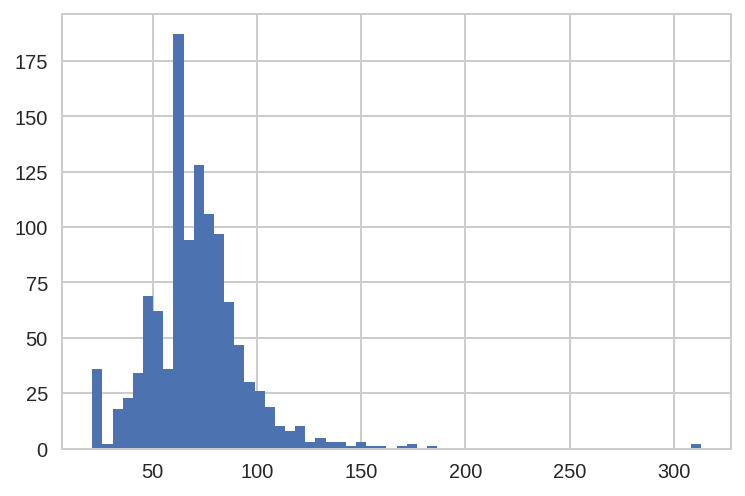

In [42]:
plt.hist(temp_LotFrontage, bins=60)
plt.show()
# Look at how skewed this data is!
# Fill in the Nan values with the mode instead of the mean
# Did not assume that if there was no Lot Frontage that Lot Frontage was zero.
# It could just be missing information.

In [43]:
df_house['LotFrontage'].replace(np.nan, 60, inplace=True)

In [44]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1385 entries, 0 to 1459
Data columns (total 81 columns):
Id               1385 non-null int64
MSSubClass       1385 non-null int64
MSZoning         1385 non-null object
LotFrontage      1385 non-null float64
LotArea          1385 non-null int64
Street           1385 non-null object
Alley            1385 non-null object
LotShape         1385 non-null object
LandContour      1385 non-null object
Utilities        1385 non-null object
LotConfig        1385 non-null object
LandSlope        1385 non-null object
Neighborhood     1385 non-null object
Condition1       1385 non-null object
Condition2       1385 non-null object
BldgType         1385 non-null object
HouseStyle       1385 non-null object
OverallQual      1385 non-null int64
OverallCond      1385 non-null int64
YearBuilt        1385 non-null int64
YearRemodAdd     1385 non-null int64
RoofStyle        1385 non-null object
RoofMatl         1385 non-null object
Exterior1st      1385 non

# 3. Identify fixed features that can predict price.

In [45]:
list_fixed_features_cat = [
    'MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'YearBuilt',
    'Foundation',
    'BsmtFullBath',
    'BsmtHalfBath',
    'FullBath',
    'HalfBath',
    'BedroomAbvGr',
    'KitchenAbvGr',
    'TotRmsAbvGrd',
    'Functional',
    'Fireplaces',
    'GarageType',
    'GarageYrBlt',
    'GarageFinish',
    'GarageCars',
    'PavedDrive',
    'MiscFeature',
    'MoSold',
    'YrSold',
    'SaleType',
    'SaleCondition'
]

In [46]:
list_fixed_features_num = [
    'LotFrontage',
    'LotArea',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'TotalBsmtSF',
    'BsmtUnfSF',
    '1stFlrSF',
    '2ndFlrSF',
    'GrLivArea',
    'WoodDeckSF',
    'OpenPorchSF',
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch',    
    'PoolArea',
    'MiscVal',
    'GarageArea'
]

In [47]:
list_unfixed_features = [col for col in df_house if col not in list_fixed_features_cat + list_fixed_features_num]
list_unfixed_features

['Id',
 'OverallQual',
 'OverallCond',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'KitchenQual',
 'FireplaceQu',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'SalePrice']

In [48]:
df_fixed_features = df_house[list_fixed_features_cat + list_fixed_features_num]
df_fixed_features.sample(5)

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,2ndFlrSF,GrLivArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,GarageArea
254,20,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,1314,250,0,0,0,0,0,0,294
319,80,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,...,0,1472,233,48,0,0,0,0,0,588
98,30,RL,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,Edwards,...,0,835,0,0,77,0,0,0,400,366
213,20,RL,Pave,NA,IR2,Lvl,AllPub,CulDSac,Gtl,CollgCr,...,0,990,224,0,0,0,0,0,0,576
1146,20,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,...,0,1298,165,26,0,0,0,0,0,403


In [49]:
df_fixed_features.shape

(1385, 53)

In [50]:
df_fixed_features_dummies = pd.get_dummies(df_fixed_features, dummy_na = True, columns=list_fixed_features_cat)
df_fixed_features_dummies.shape

(1385, 469)

In [51]:
df_fixed_features_dummies.columns

Index([u'LotFrontage', u'LotArea', u'MasVnrArea', u'BsmtFinSF1', u'BsmtFinSF2',
       u'TotalBsmtSF', u'BsmtUnfSF', u'1stFlrSF', u'2ndFlrSF', u'GrLivArea',
       ...
       u'SaleType_Oth', u'SaleType_WD', u'SaleType_nan',
       u'SaleCondition_Abnorml', u'SaleCondition_AdjLand',
       u'SaleCondition_Alloca', u'SaleCondition_Family',
       u'SaleCondition_Normal', u'SaleCondition_Partial',
       u'SaleCondition_nan'],
      dtype='object', length=469)

# 4. Train a model on pre-2010 data and evaluate its performance on the 2010 houses.

In [52]:
# split the data by YrSold for pre-2010 vs. 2010
# the train-test-split seems very specific

In [53]:
df_fixed_features['YrSold'].unique()

array([2008, 2007, 2006, 2009, 2010])

In [54]:
df_fixed_features['YrSold'].value_counts()

2009    321
2007    313
2006    299
2008    288
2010    164
Name: YrSold, dtype: int64

In [55]:
# predict on SalePrice (which is no longer part of the df_fixed_features_dummies or df_fixed_features dataframe)
# do a manual train/test/split

# X_train will be all the feature columns and rows for which sales occured in years prior to 2010
# X_test will be all the feature columns and rows for which sales occured in 2010
# y_train will be all the sales prices for which the sale occured prior to 2010
# y_test will be all the sales prices for which the sale occured in 2010

In [212]:
y_train = df_house[df_house['YrSold'] != 2010]['SalePrice']
y_test = df_house[df_house['YrSold'] == 2010]['SalePrice']

In [213]:
y_train.shape

(1221,)

In [214]:
y_test.shape

(164,)

In [255]:
X_test = df_fixed_features_dummies[df_fixed_features_dummies['YrSold_2010.0'] != 0]
X_train = df_fixed_features_dummies[df_fixed_features_dummies['YrSold_2010.0'] == 0]

In [256]:
X_test.shape

(164, 469)

In [257]:
X_train.shape

(1221, 469)

In [258]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

# This ia feature dense data frame made more dense by getting dummies on several categorical featurs.


In [259]:
from sklearn.feature_selection import f_regression

In [260]:
rfr_pipe = Pipeline([
    ('skb', SelectKBest(score_func=f_regression, k=100)),
    ('scaler', StandardScaler()),
    ('regr', RandomForestRegressor(verbose=1, n_jobs=-1))
])

In [261]:
params = {
    'regr__n_estimators': [75, 100, 125], 
}

In [262]:
gs_rfr = GridSearchCV(rfr_pipe,
                      param_grid=params,
                      n_jobs=-1,
                      cv=ShuffleSplit(n_splits=5, random_state=42), verbose=1)

In [263]:
gs_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.0s finished
[Parallel(n_job

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=Pipeline(steps=[('skb', SelectKBest(k=100, score_func=<function f_regression at 0x7fee2b7159b0>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regr', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
       ...imators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=1, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'regr__n_estimators': [75, 100, 125]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [264]:
pd.DataFrame(gs_rfr.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_regr__n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,1.790043,0.154923,0.831170,0.972354,125,{u'regr__n_estimators': 125},1,0.786185,0.971688,0.855259,...,0.757229,0.974178,0.883560,0.971607,0.873618,0.973190,0.317689,0.055988,0.050235,0.001147
0,1.204150,0.155353,0.826286,0.972024,75,{u'regr__n_estimators': 75},2,0.778327,0.972229,0.858965,...,0.760810,0.973061,0.873038,0.971902,0.860289,0.973761,0.044353,0.054996,0.046898,0.001568
1,1.542730,0.135707,0.821031,0.971121,100,{u'regr__n_estimators': 100},3,0.757280,0.973159,0.849241,...,0.754755,0.970565,0.883269,0.970950,0.860611,0.971394,0.072066,0.050380,0.054208,0.001190


In [265]:
gs_rfr.best_score_

0.83117008780162149

In [266]:
gs_rfr.score(X_train, y_train)

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.1s finished


0.97570650125410152

In [267]:
gs_rfr.score(X_test, y_test)

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    0.1s finished


0.8634395392738119

In [268]:
gs_rfr.best_params_

{'regr__n_estimators': 125}

In [232]:
skb_mask = gs_rfr.best_estimator_.named_steps['skb'].get_support()
#sfm_mask = gs_en_pipe.best_estimator_.named_steps['sfm'].get_support()

In [233]:
skb_mask.sum()

100

In [234]:
feat_cols = X_train.columns[skb_mask]

In [235]:
feat_imps = gs_rfr.best_estimator_.named_steps['regr'].feature_importances_

In [236]:
cols_and_imps = list(zip(feat_cols, feat_imps))
cols_and_imps

[('LotFrontage', 0.0076772535837026238),
 ('LotArea', 0.017319586726263568),
 ('MasVnrArea', 0.014544843564405925),
 ('BsmtFinSF1', 0.044249729937205454),
 ('TotalBsmtSF', 0.0599018744398499),
 ('BsmtUnfSF', 0.011284032515820185),
 ('1stFlrSF', 0.03533070357348269),
 ('2ndFlrSF', 0.031166800299257703),
 ('GrLivArea', 0.24123804151792849),
 ('WoodDeckSF', 0.0076036960812724992),
 ('OpenPorchSF', 0.012542128390968563),
 ('EnclosedPorch', 0.0016935718336933765),
 ('ScreenPorch', 0.0010820593951714986),
 ('GarageArea', 0.034628110460578905),
 ('MSSubClass_30.0', 0.0011161381269302157),
 ('MSSubClass_50.0', 0.00040496971433802415),
 ('MSSubClass_60.0', 0.001694766963536809),
 ('MSSubClass_90.0', 0.00045342677405862687),
 ('MSSubClass_160.0', 4.0401231813398136e-05),
 ('MSZoning_RL', 0.0032378586133052648),
 ('MSZoning_RM', 0.00040740353119930251),
 ('Alley_Grvl', 0.00042944770792472449),
 ('Alley_NA', 0.00082397439172024033),
 ('LotShape_IR1', 0.0006889867861610842),
 ('LotShape_IR2', 0.000

In [237]:
cols_and_imps.sort(key=lambda x:x[1], reverse=True)

In [238]:
df_fixed_feat_imp = pd.DataFrame(cols_and_imps)
df_fixed_feat_imp.rename(columns={1:'importance',0:'column'}, inplace=True)
df_fixed_feat_imp.head()

,column,importance
0,GarageCars_3.0,0.378813
1,GrLivArea,0.241238
2,TotalBsmtSF,0.059902
3,BsmtFinSF1,0.044250
4,1stFlrSF,0.035331


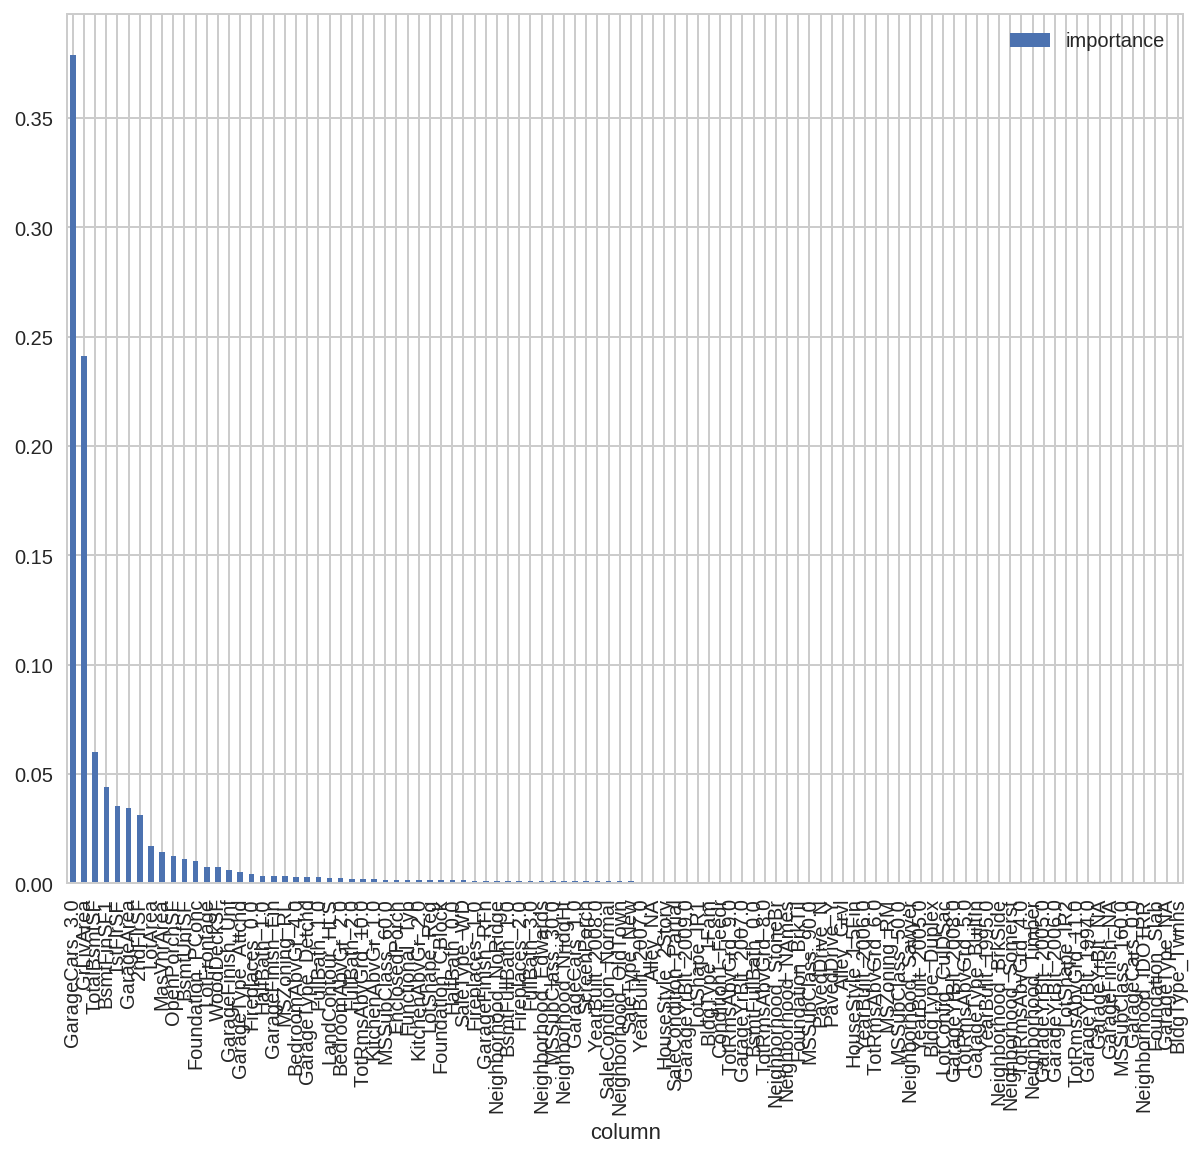

In [239]:
df_fixed_feat_imp.plot.bar('column','importance', figsize=(10,8))
plt.show()

In [240]:
# I'm concerned only with features that have importance > 0.005
# create a mask for the data frame of feature importances
df_fixed_feat_imp[df_fixed_feat_imp['importance'] > 0.005]

,column,importance
0,GarageCars_3.0,0.378813
1,GrLivArea,0.241238
2,TotalBsmtSF,0.059902
3,BsmtFinSF1,0.044250
4,1stFlrSF,0.035331
5,GarageArea,0.034628
6,2ndFlrSF,0.031167
7,LotArea,0.017320
8,MasVnrArea,0.014545
9,OpenPorchSF,0.012542


In [241]:
y_preds = gs_rfr.predict(X_test)

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    0.1s finished


In [242]:
y_preds.shape

(1221,)

In [243]:
X_test.shape

(1221, 469)

In [244]:
y_test.shape

(164,)

##  Run a different model with a feature selector (Lasso & Elastic Net) instead 

In [190]:
en_pipe = Pipeline([
    ('scalar', StandardScaler()),
    ('sfm', SelectFromModel(Lasso(alpha=0.75))),
    ('rgr', ElasticNet())
])

In [191]:
en_params = {
    #'sfm__estimator': [SelectFromModel([Lasso(alpha=a) for a in np.logspace(2, 5, 4)])],
    'rgr': [ElasticNet(alpha = a, l1_ratio = l) for a in np.linspace(0, 1, 7) for l in np.linspace(0.25, 0.5, 5)]
}

In [192]:
en_gs = GridSearchCV(en_pipe, param_grid=en_params, cv=5, n_jobs=-1, verbose=1)

In [193]:
en_gs.fit(X_train, y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/pipeline.py:270: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/pipeline.py:270: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 17

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('scalar', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sfm', SelectFromModel(estimator=Lasso(alpha=0.75, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=Fals...alse, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'rgr': [ElasticNet(alpha=0.0, copy_X=True, fit_intercept=True, l1_ratio=0.25,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False), ElasticNet(alpha=0.0, copy_X=True, fit_intercept=True, l1_rati...alse, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
    

In [194]:
en_gs.best_estimator_

Pipeline(steps=[('scalar', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sfm', SelectFromModel(estimator=Lasso(alpha=0.75, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=Fals...alse, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])

In [195]:
en_gs.best_params_

{'rgr': ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.25,
       max_iter=1000, normalize=False, positive=False, precompute=False,
       random_state=None, selection='cyclic', tol=0.0001, warm_start=False)}

In [196]:
pd.DataFrame(en_gs.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_rgr,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
30,0.434495,0.006634,0.773429,0.875445,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...","{u'rgr': ElasticNet(alpha=1.0, copy_X=True, fi...",1,0.837861,0.863230,0.775086,...,0.781870,0.872099,0.838101,0.866559,0.633962,0.898466,0.031422,0.001680,0.074637,0.012421
31,0.426676,0.005786,0.772671,0.878357,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...","{u'rgr': ElasticNet(alpha=1.0, copy_X=True, fi...",2,0.838322,0.866215,0.774371,...,0.781773,0.875265,0.837784,0.869492,0.630834,0.901072,0.037393,0.000044,0.075825,0.012276
32,0.428960,0.005791,0.771582,0.881330,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...","{u'rgr': ElasticNet(alpha=1.0, copy_X=True, fi...",3,0.838568,0.869268,0.773405,...,0.781238,0.878509,0.837229,0.872497,0.627195,0.903709,0.035835,0.000031,0.077117,0.012117
25,0.456929,0.005807,0.771578,0.881334,"ElasticNet(alpha=0.83333333333333326, copy_X=T...","{u'rgr': ElasticNet(alpha=0.83333333333333326,...",4,0.838565,0.869272,0.773401,...,0.781234,0.878513,0.837225,0.872501,0.627190,0.903713,0.077554,0.000048,0.077117,0.012117
26,0.407371,0.005067,0.770364,0.883863,"ElasticNet(alpha=0.83333333333333326, copy_X=T...","{u'rgr': ElasticNet(alpha=0.83333333333333326,...",5,0.838571,0.871872,0.772367,...,0.780365,0.881285,0.836543,0.875066,0.623693,0.905936,0.057684,0.001603,0.078284,0.011973


In [197]:
en_gs.best_estimator_.steps

[('scalar', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('sfm',
  SelectFromModel(estimator=Lasso(alpha=0.75, copy_X=True, fit_intercept=True, max_iter=1000,
     normalize=False, positive=False, precompute=False, random_state=None,
     selection='cyclic', tol=0.0001, warm_start=False),
          prefit=False, threshold=None)),
 ('rgr', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.25,
        max_iter=1000, normalize=False, positive=False, precompute=False,
        random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]

In [198]:
# cannot use get_support() with Elastic Net so I don't know which features were kept.

# 5. Characterize your model. How well does it perform? What are the best estimates of price?

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones (explained by the *renovatable* features).

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [77]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [78]:
# A: